# Feedforward Neural Network Models

In this notebook, we will learn how to use a neural network model to predict the energy of points on the Müller-Brown potential energy surface.

In [3]:
# Import all important packages

from math import exp, pow
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import TensorDataset, DataLoader

%pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


## 01. What is Müller-Brown Potential Energy Function

The müller-Brown potential stands as one of computational chemistry's most enduring benchmark systems: a deceptively simple two-dimensional analytical surface that has challenged algorithms for nearly five decades. This potential energy function, which captures that essential challenges of real chemical reaction landscpaes while maintaing computaitonal simplicity, was introduced by Klaus Müller and L.D. Brown. 

The Müller-Brown potential combines four two-dimension Gaussian functions:

$$ V(x,y) = \sum_{k=0}^3 A_k \exp[a_k(x-x_k^0)^2 + b_k(x-x_k^0)(y-y_k^0)+c_k(y-y_k^0)]$$

**Standard Parameters**

The parameteres values that define the Müller-Brown surface are:

| k | $A_k$ | $a_k$ | $b_k$ | $c_k$ | $x_k^{0}$ | $y_k^{0}$ |
|---|------:|------:|------:|------:|----------:|----------:|
| 1 | -200  | -1    | 0     | -10   |  1        | 0         |
| 2 | -100  | -1    | 0     | -10   |  0        | 0.5       |
| 3 | -170  | -6.5  | 11    | -6.5  | -0.5      | 1.5       |
| 4 |  15   |  0.7  | 0.6   |  0.7  | -1        | 1         |

For further reading: https://hunterheidenreich.com/notes/computational-chemistry/benchmark-problems/muller-brown-1979/

Let's define this function with the corresponding parameters with a function.

In [4]:
# Müller brown potential funciton with the parameters mentioned above
def mueller_brown_potential(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x_0 = [1, 0, -0.5, -1]
    y_0 = [0, 0.5, 1.5, 1]
    z = 0
    for k in range(4):
        z = z + 0.1 * A[k] * np.exp(a[k] * (x-x_0[k])**2 + b[k] * (x-x_0[k]) * (y-y_0[k]) + c[k] * (y-y_0[k])**2)
    return z

## 02. Generate Training data

First, we need to generate data to train the nerual network

In [5]:
# generate x and y or a grid
x_range = np.arange(-1.8, 1.4, 0.1, dtype=np.float32)
y_range = np.arange(-0.4, 2.4, 0.1, dtype=np.float32)
X, Y = np.meshgrid(x_range, y_range)

# Compute the potential energy at each point on the grid
mueller_brown_potential_vectorized = np.vectorize(mueller_brown_potential, otypes=[np.float32])
Z = mueller_brown_potential_vectorized(X, Y)

# keep only low-energy points for training
train_mask = Z < 10
X_train, Y_train, Z_train = X[train_mask], Y[train_mask], Z[train_mask]



print(f"Z_min: {np.min(Z)}, Z_max: {np.max(Z)}")
print(f"Size of the training set set: {len(Z_train)}")

Z_min: -14.599801063537598, Z_max: 1194.4622802734375
Size of the training set set: 696


## 03. Visualizing Training Data: 3D projection surface

We will now create a 3D plot of our training data. We are going to use the `plotly` library to create an interactive plot. We only plot the part of the potential energy surface that is below 15 [AU]. For the actual training, only the part that is below 10 [AU] will be use.

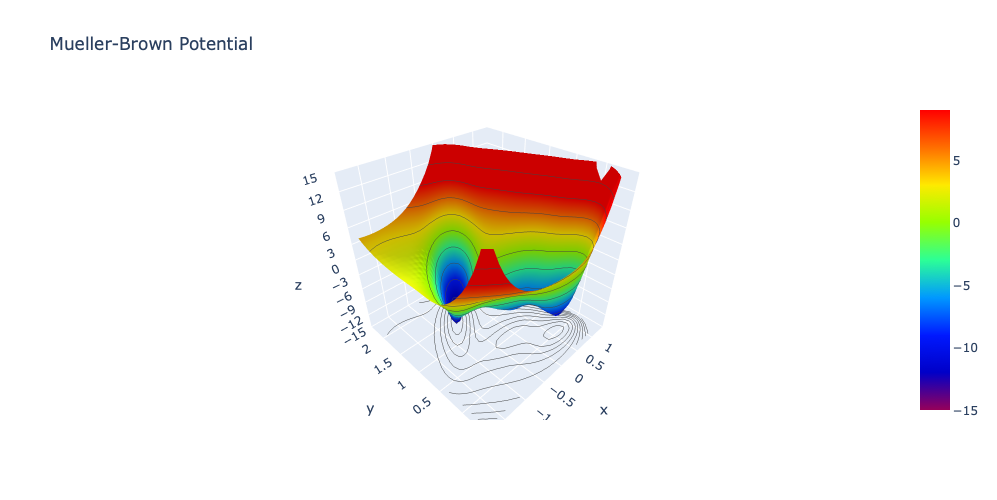

In [6]:
# Create a 3D surface plot of the Mueller-Brown potential energy surface
fig = go.Figure(
    data=[
        go.Surface(
            z=Z, 
            x=X, 
            y=Y, 
            colorscale="rainbow",
            cmin=-15,
            cmax=9
        )
    ]
)

# Add contour lines projected onto the surface along the z-direction
# This helps visualize energy basing and saddle regions

fig.update_traces(
    contours_z=dict(
        show=True,
        project_z=True
    )
)

# Configure layout and 3D scene properties

fig.update_layout(
    title="Mueller-Brown Potential",
    width = 500,
    height = 500,
    scene = dict(
    zaxis = dict(
        dtick=3, 
        range=[-15, 15]
    ),
    camera_eye = dict
        (x=-1.2, y=-1.2, z=1.2
        ) 
    )
)

## 04. Visualizing Trainign Data: Contour Surface

Now, we will create a contour surface plot of our training data. Since we will plot similar contour surface plots later, we will define a function to do this. 

    

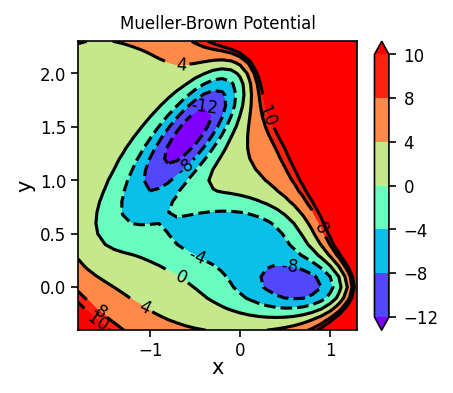

In [7]:
# 2D contour map of a potential energy surface
def plot_contour_map(X, Y, Z, ax, title, colorscale="rainbow", levels=None):
    if levels is None:
        levels = [-12, -8, -4, 0, 4, 8, 10]

    # Black contour lines (These are iso-energy lines)
    ct = ax.contour(X, Y, Z, levels, colors="k")
    ax.clabel(ct, inline=True, fmt="%3.0f", fontsize=8)

    # This creates energy regions
    ct = ax.contourf(X, Y, Z, levels, cmap = colorscale, extend="both", vmin=levels[0], vmax=levels[-1])
    
    ax.set_xlabel("x", labelpad=-0.75)
    ax.set_ylabel("y", labelpad=2.5)
    ax.tick_params(axis="both", pad=2, labelsize=8)
    cbar = plt.colorbar(ct)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(title, fontsize=8)

fix, ax = plt.subplots(figsize=(3, 2.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax, title="Mueller-Brown Potential")

Beautiful plot! I love it!

## 05. Defining the Neural Network Class

### 05.01 A Basic Neural Network

Here, we illustrate a simple feed-forward neural network with one hidden layer.
The input features $(X, Y)$ are linearly combined using the weight matrix $W^{[1]}$ and bias vector
$b^{[1]}$ to form the pre-activation values
\begin{equation}
Z^{[1]} = W^{[1]}
\begin{pmatrix}
X \\ Y
\end{pmatrix}
+ b^{[1]}.
\end{equation}

A nonlinear activation function, here the hyperbolic tangent, is applied element-wise to obtain the
hidden-layer activations
\begin{equation}
A^{[1]} = \tanh\!\left(Z^{[1]}\right).
\end{equation}

The output layer combines the hidden activations using weights $W^{[2]}$ and bias $b^{[2]}$,
\begin{equation}
Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]},
\end{equation}
and the final network prediction is given by
\begin{equation}
y^{\mathrm{pred}} = \tanh\!\left(Z^{[2]}\right).
\end{equation}

This structure highlights the essential components of a neural network: linear transformations,
bias terms, and nonlinear activation functions, which together enable the learning of nonlinear
input–output mappings.

In [9]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Set default data type to float32
torch.set_default_dtype(torch.float32)

class NeuralNetwork(nn.Module):
    def __init__(self, n_hidden=20):
        """
        Args:
        n_hidden (int) : Number of neurons in the hidden layer
        
        """
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(2, n_hidden), # Linear function taking 2 inputs and outputs data for n_hidden neurons.
            nn.Tanh(),
            nn.Linear(n_hidden, 1) # LInear function taking data from n_hidden neurons after passing through the activation function.
        )

    def forward(self, x):
        return self.linear(x)

def train_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device=device):
    """
    Performs a training with model trying to learn on data_loader
    """
    model.train() # Set the model to training mode
    model.to(device)
    
    train_loss = 0
    num_batches = len(data_loader)
    
    for X, y in data_loader:
        # send data to GPU or CPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred.squeeze(), y)
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad() # Zero out the gradients from the previous iteration to replace them.

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer ste
        optimizer.step()
        

    train_loss /= num_batches

    return train_loss
    

### 05.02 Loading PyTorch and Training Data

In this data we have two features, namely : X_train and Y_train. Output of it: Z_train

In [10]:
# turn Numpy arrays into PyTorch tensors

X_tensor = torch.from_numpy(np.column_stack((X_train, Y_train)))
Y_tensor = torch.from_numpy(Z_train)

dataset = TensorDataset(X_tensor, Y_tensor)
print(f"Size of the training dataset: {len(dataset)}")

Size of the training dataset: 696


### 05.03 Setup the hyperparameters and the model

Now, we can train the neural network model. We will finish our training when the desired number of epochs has been reached. We will also define hyperparametes.

**Epochs** - Number of forward/backwars passes through the entire nerual network.
**Learning rate** - Determines the step size as we try to minimize the loss function. A faster learning rate would have a larager step size. 
**Stochastic Gradient Descent (SGD)** - The algo used for minimizing the loss function.

Note: In this example, there are 696 training points broken into 21 batches of batch size 8.

In [11]:
# Set random seed for reproducibility
torch.manual_seed(314)

# Hyperparametets
batch_size = 32
epochs = 1000
learning_rate = 0.01
n_hidden = 20

# load the dataset 
train_loader = DataLoader(dataset, batch_size, shuffle=True)

# model 
model = NeuralNetwork(n_hidden)

### 05.04 Setup loss function and optimizer


In [12]:
# Loss function
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
for epoch in range(epochs):
    train_loss = train_step(model = model, 
              data_loader = train_loader,
              loss_fn = loss_fn,
              optimizer = optimizer,
              device = device)
    if epoch % 100 == 0:
        print(f"epoch : {epoch} | loss : {train_loss:.2f}")

epoch : 0 | loss : 26.49
epoch : 100 | loss : 8.35
epoch : 200 | loss : 2.07
epoch : 300 | loss : 1.60
epoch : 400 | loss : 1.29
epoch : 500 | loss : 1.15
epoch : 600 | loss : 0.99
epoch : 700 | loss : 0.86
epoch : 800 | loss : 0.84
epoch : 900 | loss : 0.79


### 05.05 Plotting Reference, Predicted, and Difference surface

Finally, we will plot the Müller-Brown potential energy surface using the analytical function (**reference**), using the neural network (**predicted**), and we will show the diffrence between the predicted and reference surfaces.

Shape of Z: (28, 32) | Shape of Z_pred: (28, 32)


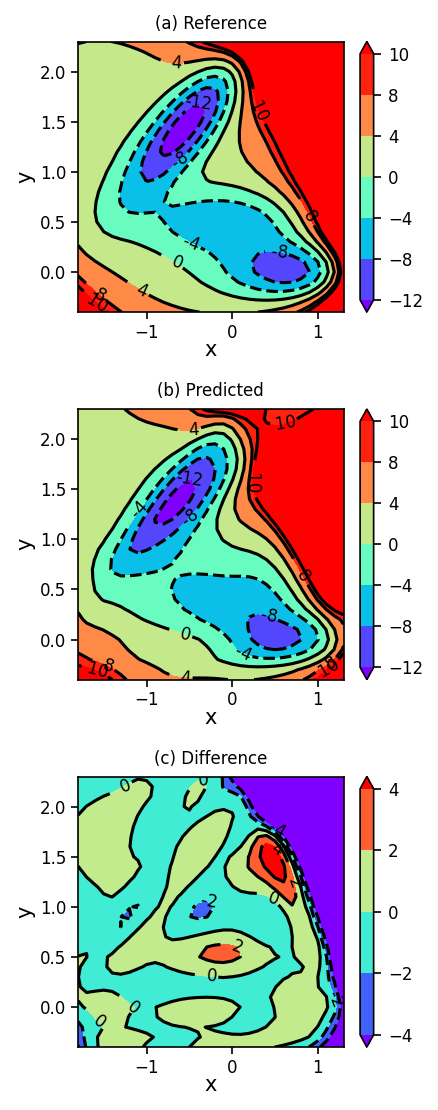

In [14]:
# Put the model in eval model
model.eval()

Z_pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))).detach().numpy().reshape(Z.shape)
print(f"Shape of Z: {Z.shape} | Shape of Z_pred: {Z_pred.shape}")

# Z_diff is the diffrenece between the actual value and the prediction
Z_diff = Z_pred - Z


fig, ax = plt.subplots(3, figsize=(3, 7.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax[0], title="(a) Reference")
plot_contour_map(X, Y, Z_pred, ax=ax[1], title="(b) Predicted")
plot_contour_map(X, Y, Z_diff, ax=ax[2], title="(c) Difference", levels=[-4, -2, 0, 2, 4])
fig.tight_layout()


### 05.06 Taking a Look at the NN parameters

In order to take a closer look at the neural network parameters, we will plug them into the linear functions.

In [15]:
print("model:", model)


for name, param in model.named_parameters():
    if name == 'linear.0.weight': weights0 = param.data.detach().numpy()
    elif name == 'linear.0.bias': bias0 = param.data.detach().numpy()
    elif name == 'linear.2.weight': weights2 = param.data.detach().numpy()
    elif name == 'linear.2.bias': bias2 = param.data.detach().numpy()

model: NeuralNetwork(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=1, bias=True)
  )
)


Let's manually reconstructs the forward pass of the neural network, step by step, using the learned weight and biases.

model(xy0) $\equiv$ (linear -> tanh -> linear) computed by hand

In [16]:
# Choose a test input and evaluate the model normally
xy0 = torch.tensor([-0.5, 1.5], dtype=torch.float32)
z0 = model(xy0)

#first linear function (Z1 = W1 * x + b1)
v1 = np.zeros(n_hidden)
for i in range(n_hidden):
    v1[i] += weights0[i, 0] * xy0[0] + weights0[i, 1] * xy0[1] + bias0[i]


#activation function, A1 = tanh(Z1)
v2 = np.zeros(n_hidden)
for i in range(n_hidden):
    v2[i] = np.tanh(v1[i])

#second linear function, z_pred = W2 * A1 + b2
z_pred = 0.0
for i in range(n_hidden): 
    z_pred += weights2[0,i] * v2[i]
z_pred += bias2[0]

print("z0:", z0, "z_pred:", z_pred)

z0: tensor([-13.0164], grad_fn=<ViewBackward0>) z_pred: -13.016362176486812


## 06 A more Automated/Redefined Implementation

### 06.01 A PyTorch-Lightning Implementation

**PyTorch Lightning** is a deep learning framework for professional AI researches and machine learning engineers who need maximal flexibiltiy without sacrificing performance at scales. 
Further reading: https://lightning.ai/docs/pytorch/stable/starter/introduction.html

In [23]:
class NeuralNetworkLightning(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        # Scalar loss
        loss = f.mse_loss(y_pred.squeeze(), y)
        # Ligthing-managed logging
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        # Using the Adam optimization algo instead of SGD
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.learning_rate)
        return [optimizer]        

In [26]:
%%capture
# Set random seed for reproducibiliity
pl.seed_everything(314, workers=True)

# Traing hyperparameters
batch_size = 32
epochs = 1000
learning_rate = 0.01
n_hidden = 20

# Wrap dataset into mini-batches and shuffle each epoch
train_loader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True)

# Log metrics to CSV files under logs_csv/version_0
csv_logger = CSVLogger("logs_csv", version=0)

# Trainer = execution engine (loops, devices, determinism)
trainer = pl.Trainer(
    max_epochs=epochs,
    logger=csv_logger, 
    deterministic=True
)

# LightningModule wrapping a pure PyTorch model
model = NeuralNetworkLightning(
    NeuralNetwork(n_hidden),
    learning_rate
)

# Start traing loop
trainer.fit(model, train_loader)

Seed set to 314
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.

  | Name  | Type          | Params | Mode  | FLOPs
--------------------------------------------------------
0 | model | NeuralNetwork | 81     | train | 0    
--------------------------------------------------------
81        Trainable params
0         Non-trainable params
81        Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
0         Total Flops
`Trainer.fit` stopped: `max_epochs=100

### 06.02 Plotting Traning Error

Text(0, 0.5, 'Training Errors')

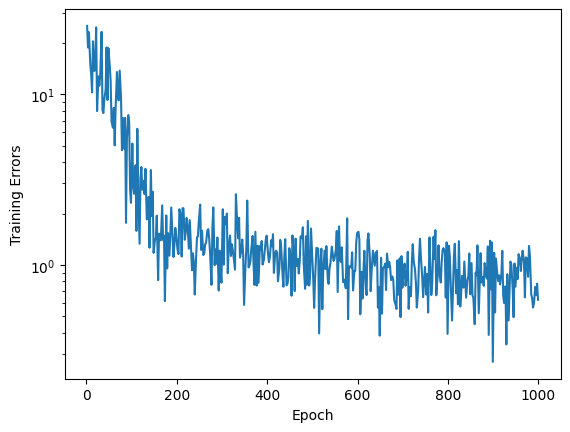

In [28]:
# Read the file
loss = pd.read_csv("logs_csv/lightning_logs/version_0/metrics.csv")
fix, ax = plt.subplots()
ax.semilogy(loss["epoch"], loss["train_loss"])
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Errors")

### Plotting Reference, Predicted, and Difference Surfaces

Again, we plot the reference, predicted, and difference surfaces using the more refined neural network implementation.

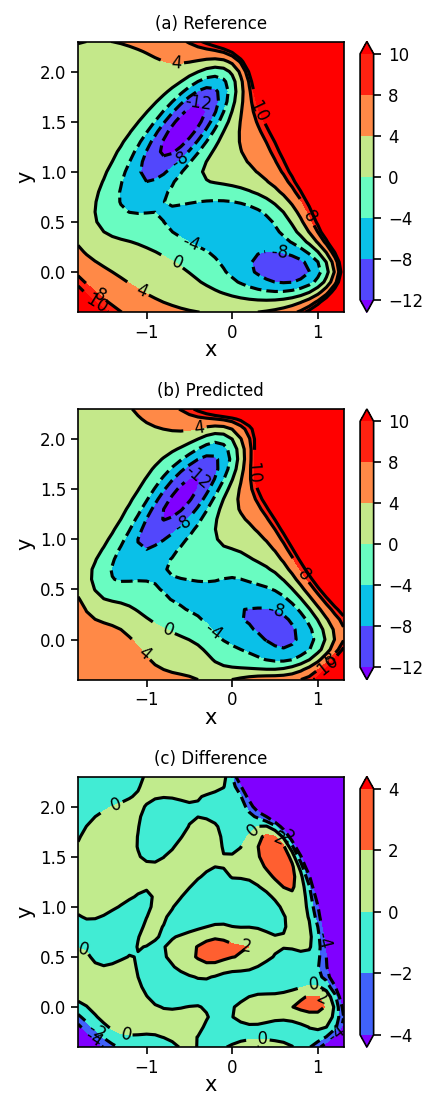

In [43]:
# Set the model to evaluiaiton mode
model.eval()
Z_pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))).detach().numpy().reshape(Z.shape)
Z_diff = Z_pred - Z

fig, ax = plt.subplots(3, figsize=(3, 7.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax[0], title="(a) Reference")
plot_contour_map(X, Y, Z_pred, ax=ax[1], title="(b) Predicted")
plot_contour_map(X, Y, Z_diff, ax=ax[2], title="(c) Difference", levels=[-4, -2, 0, 2, 4])
fig.tight_layout()

## 07. Train with Energy and Gradient

In this module, we will use not only energy but also the energy gradient to fit our nerual network. The following steps are necessary: First, we define our model, then the loss function and optimization step. Finally, we write the function for the training loop. 
```python

model -> loss function & optimizer -> training loop -> evaluaiton

```

Recalled the Mueller-Brown potential energy surface:
$$ V(x,y) = \sum_{k=0}^{3} A_k \exp[a_k(x - x_k^0)^2] + b_k (x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2]$$

Derivaties with respect to $x$ and $y$ for the Muller-Brown potential energy surface is defined as:

$$ \frac{dV(x,y)}{dx} = \sum_{k=0}^{3} A_k \exp[a_k(x - x_k^0)^2] + b_k (x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2] [2a_k(x-x_k^0) + b_k(y-y_k^0)]$$
$$ \frac{dV(x,y)}{dx} = \sum_{k=0}^{3} A_k \exp[a_k(x - x_k^0)^2] + b_k (x-x_k^0)(y-y_k^0) + c_k(y-y_k^0)^2] [2b_k(x-x_k^0) + 2c_k(y-y_k^0)]$$


In [46]:
# Gradine of the Müller brown potential funciton
def mueller_brown_potential_gradient(x, y):
    A = [-200, -100, -170, 15]
    a = [-1, -1, -6.5, 0.7]
    b = [0, 0, 11, 0.6]
    c = [-10, -10, -6.5, 0.7]
    x_0 = [1, 0, -0.5, -1]
    y_0 = [0, 0.5, 1.5, 1]
    dx = 0
    dy = 0
    for k in range(4):
        dx = dx + 0.1 * A[k] * np.exp(a[k] * (x-x_0[k])**2 + b[k] * (x-x_0[k]) * (y-y_0[k]) + c[k] * (y-y_0[k])**2) * (2*a[k]*(x-x_0[k]) + b[k]*(y-y_0[k]))
        dy = dy + 0.1 * A[k] * np.exp(a[k] * (x-x_0[k])**2 + b[k] * (x-x_0[k]) * (y-y_0[k]) + c[k] * (y-y_0[k])**2) * (b[k]*(x-x_0[k]) + 2 * c[k]*(y-y_0[k]))
    return dx, dy

`np.vectorize()` is convenience wrapper, not real vectorization. It takes a scalar Python function and returns a new function that applies it element-by-element over NumPy arrays.

In [84]:
# Compute the potential energy gradient at each point on the grid
mueller_brown_potential_gradient_vectorized = np.vectorize(mueller_brown_potential_gradient, otypes=[np.float32, np.float32])
dX, dY = mueller_brown_potential_gradient_vectorized(X, Y)

# Keep only low-energy points for the training
dX_train, dY_train = dX[train_mask], dY[train_mask]

dX_tensor = torch.from_numpy(np.column_stack((dX_train, dY_train)))
dataset = TensorDataset(X_tensor, Y_tensor, dX_tensor)
X_tensor.shape, Y_tensor.shape, dX_tensor.shape

(torch.Size([696, 2]), torch.Size([696]), torch.Size([696, 2]))

In [106]:
# Write the main model for the train_step_with_gradient step

def train_step_with_gradient(model: torch.nn.Module,
                            data_loader: torch.utils.data.DataLoader,
                            loss_fn: torch.nn.Module, 
                            optimizer: torch.optim.Optimizer,
                            device: torch.device=device):
    """
    Performs a training with model trying to learn on data_laoder
    """
    model.train() # set the model to training mode
    model.to(device)

    train_loss = 0
    train_loss_energy = 0
    train_loss_gradient = 0
    num_batches = len(data_loader)
    
    for X, y, dX in data_loader:
        # Send data to GPU (if there)
        X, y, dX = X.to(device), y.to(device), dX.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Forward pass with gradients
        dX_pred = torch.autograd.grad(y_pred, X, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
        
        # 3. Calculate the loss of the energy
        loss_energy = loss_fn(y_pred.squeeze(), y)

        # 4. Calculate the loss of the gradient
        loss_gradient = loss_fn(dX_pred.squeeze(), dX)

        # 5. Total loss
        loss = loss_energy + loss_gradient

        # 5. Optimizer zero grad
        optimizer.zero_grad()

        # 6. loss backward
        loss.backward()

        # 7. Optimizer step
        optimizer.step()

        with torch.no_grad():
            train_loss_energy += loss_energy.item()
            train_loss_gradient += loss_gradient.item()
            train_loss += loss.item()

    train_loss /= num_batches
    train_loss_gradient /= num_batches
    train_loss_energy /= num_batches

    return train_loss, train_loss_gradient, train_loss_energy

In [107]:
# Set random seed for reporducibility
torch.manual_seed(314)

# Set the hyperparameters
batch_size = 32
epochs = 5000
learning_rate = 1e-2
n_hidden = 20


# Prepare the data for training
train_loader_with_gradient = DataLoader(
    dataset, 
    batch_size=batch_size,
    shuffle=True
)

# Model -> loss_fn -> Optimizer
model_with_gradient = NeuralNetwork(n_hidden=n_hidden)
loss_fn_with_gradient = torch.nn.MSELoss()
optimizer_with_gradient = torch.optim.SGD(model_with_gradient.parameters(), 
                           lr = learning_rate)


# Training loop
for epoch in range(epochs):
    X_tensor.requires_grad_(True)
    train_loss, train_loss_gradient, train_loss_energy = train_step_with_gradient(
        model = model_with_gradient,
        data_loader= train_loader_with_gradient,
        loss_fn = loss_fn_with_gradient,
        optimizer = optimizer_with_gradient, 
        device = device
    )
    if epoch % 100 == 0:
        print(f"epoch :{epoch}| train loss: {train_loss:.2f} | train loss gradient: {train_loss_gradient:.2f} | train loss energy: {train_loss_energy}")
    



epoch :0| train loss: 341.29 | train loss gradient: 313.86 | train loss energy: 27.43223658475009
epoch :100| train loss: 51.99 | train loss gradient: 49.10 | train loss energy: 2.8893730369481174
epoch :200| train loss: 30.25 | train loss gradient: 28.17 | train loss energy: 2.08096706867218
epoch :300| train loss: 28.74 | train loss gradient: 26.67 | train loss energy: 2.0707543085921896
epoch :400| train loss: 37.21 | train loss gradient: 34.64 | train loss energy: 2.569393976168199
epoch :500| train loss: 35.52 | train loss gradient: 32.79 | train loss energy: 2.730514859611338
epoch :600| train loss: 32.88 | train loss gradient: 29.75 | train loss energy: 3.1268680637533013
epoch :700| train loss: 34.50 | train loss gradient: 31.85 | train loss energy: 2.6500583480704916
epoch :800| train loss: 71.97 | train loss gradient: 63.26 | train loss energy: 8.71004867553711
epoch :900| train loss: 83.48 | train loss gradient: 73.39 | train loss energy: 10.089903614737771
epoch :1000| trai

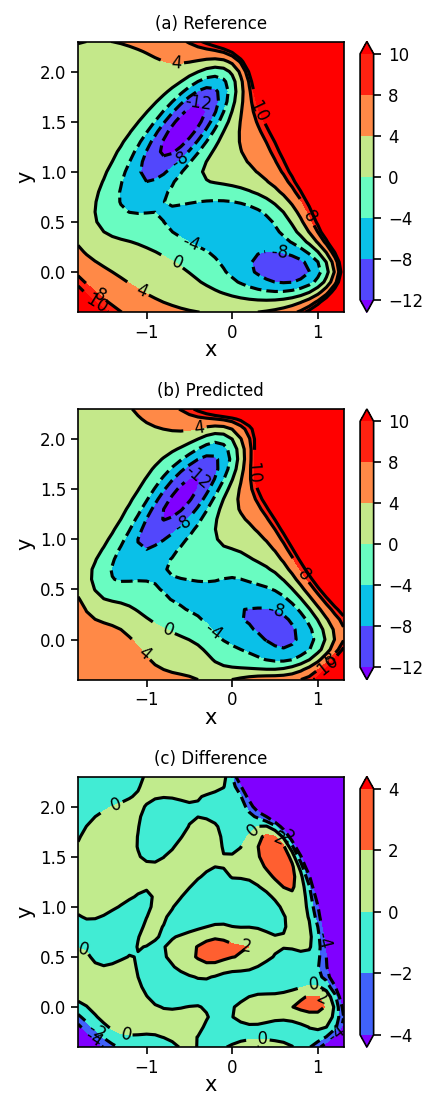

In [108]:
model.eval() # Set model to evaluation mode
Z_pred = model(torch.from_numpy(np.column_stack((X.flatten(), Y.flatten())))).detach().numpy().reshape(Z.shape)
Z_diff = Z_pred - Z

fig, ax = plt.subplots(3, figsize=(3, 7.5), dpi=150)
plot_contour_map(X, Y, Z, ax=ax[0], title='(a) Reference')
plot_contour_map(X, Y, Z_pred, ax=ax[1], title='(b) Predicted')
plot_contour_map(X, Y, Z_diff, ax=ax[2], title='(c) Difference', levels=[-4, -2, 0, 2, 4])
fig.tight_layout()